In [2]:
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
# defining the files directory and testing directory
files_dir = '/home/phuongdx/python/GAPO/gapo-ai-detect-nine-dash-line/data/train_9dash'
test_dir = '/home/phuongdx/python/GAPO/gapo-ai-detect-nine-dash-line/data/test_9dash'


class NineDashDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'duong-luoi-bo']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = NineDashDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[0]
print(img.shape, '\n',target)

length of dataset =  405 

(224, 224, 3) 
 {'boxes': tensor([[ 96.5440,  42.4925, 183.9040, 202.6131]]), 'labels': tensor([1]), 'area': tensor([13988.1377]), 'iscrowd': tensor([0]), 'image_id': tensor([0])}


In [35]:
files_dir = '/home/phuongdx/python/GAPO/gapo-ai-detect-nine-dash-line/data/train_9dash'

imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
imgs
# len(imgs)
type(imgs)

list

In [25]:
files_dir = '/home/phuongdx/python/GAPO/gapo-ai-detect-nine-dash-line/data'
paths = []
for path in os.listdir(files_dir):
    full_path = os.path.join(files_dir, path)
    paths.append(full_path)
paths

['/home/phuongdx/python/GAPO/gapo-ai-detect-nine-dash-line/data/train_9dash',
 '/home/phuongdx/python/GAPO/gapo-ai-detect-nine-dash-line/data/test_9dash']

In [37]:
images = []
for i in range(len(paths)):
    imgs = [image for image in sorted(os.listdir(paths[i]))
                        if image[-4:]=='.jpg']
    images += imgs
images
len(images)

430

In [3]:
print(img)

[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.99149156 0.99149156 0.99149156]
  [0.9908613  0.9908613  0.9908613 ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.996518   0.996518   0.996518  ]
  ...
  [0.984088   0.9977785  0.999109  ]
  [0.9915685  0.9915685  0.9915685 ]
  [0.99520624 0.99520624 0.99520624]]

 [[0.9954313  0.9954313  0.9954313 ]
  [0.99578273 0.99578273 0.99578273]
  [0.68558234 0.68558234 0.68558234]
  ...
  [0.7386555  0.7754552  0.80591744]
  [0.88394797 0.88394797 0.88394797]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         1.        ]
  [0.99530816 0.99607843 1.        ]
  [0.7392569  0.7762048  0.82871145]
  ...
  [0.35557598 0.37424657 0.41638905]
  [0.8923945  0.8923945  0.8923945 ]
  [0.9995968  0.9995968  0.9995968 ]]

 [[0.9984625  1.         1.        ]
  [0.99607843 0.99607843 0.9968487 ]


In [4]:
print(type(img))

<class 'numpy.ndarray'>


In [5]:
a = '/home/phuongdx/python/GAPO/gapo-ai-detect-nine-dash-line/data/train_9dash/000.jpg'
i = cv2.imread(a)
print(type(i))
print(i.shape)

<class 'numpy.ndarray'>
(796, 1000, 3)


In [6]:
image = cv2.resize(i,(224,224))/255
print(image.shape)
print(image)

(224, 224, 3)
[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.99215686 0.99215686 0.99215686]
  [0.99215686 0.99215686 0.99215686]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.99607843 0.99607843 0.99607843]
  ...
  [1.         0.99607843 0.98431373]
  [0.99215686 0.99215686 0.99215686]
  [0.99607843 0.99607843 0.99607843]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.68627451 0.68627451 0.68627451]
  ...
  [0.80392157 0.77647059 0.7372549 ]
  [0.88235294 0.88235294 0.88235294]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         1.        ]
  [1.         0.99607843 0.99607843]
  [0.82745098 0.77647059 0.7372549 ]
  ...
  [0.41568627 0.37254902 0.35294118]
  [0.89019608 0.89019608 0.89019608]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [0.99607843 0.9960784

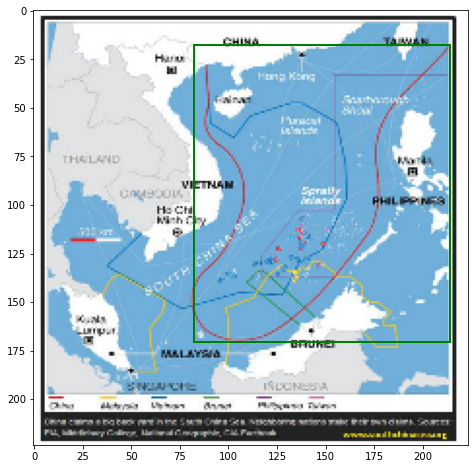

In [7]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(8,8)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'g',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[70]
plot_img_bbox(img, target)

In [8]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [9]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [10]:
# use our dataset and defined transformations
dataset = NineDashDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = NineDashDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [11]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [12]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print('Done')

Epoch: [0]  [  0/162]  eta: 0:31:44  lr: 0.000036  loss: 0.6829 (0.6829)  loss_classifier: 0.5797 (0.5797)  loss_box_reg: 0.0888 (0.0888)  loss_objectness: 0.0070 (0.0070)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 11.7584  data: 0.2866


ValueError: Caught ValueError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/phuongdx/anaconda3/envs/9_dash/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/phuongdx/anaconda3/envs/9_dash/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/phuongdx/anaconda3/envs/9_dash/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/phuongdx/anaconda3/envs/9_dash/lib/python3.6/site-packages/torch/utils/data/dataset.py", line 311, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<ipython-input-2-e840a9d3c7f1>", line 50, in __getitem__
    labels.append(self.classes.index(member.find('name').text))
ValueError: 'duong-luoi-bod' is not in list


In [ ]:
torch.save(model, r'Save Path\model.pkl\200821')

In [ ]:
model = torch.load(r'Save Path\model.pkl\200821')

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.5):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    final_prediction['labels'] = final_prediction['labels'].to('cpu')
    for i in range(len(final_prediction['scores'])):
        if final_prediction['scores'][i] < 0.6:
            final_prediction['labels'][i] = 0
        else:
            final_prediction['labels'][i] = 1
    
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
img, target = dataset_test[0]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))


In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
test_dataset = NineDashDataset(test_dir, 480, 480, transforms= get_transform(train=False))
# pick one image from the test set
img, target = test_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
print(nms_prediction)
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
def showbbox(model, img):
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():
        '''
        prediction Like:
        [{'boxes': tensor([[1492.6672,  238.4670, 1765.5385,  315.0320],
        [ 887.1390,  256.8106, 1154.6687,  330.2953]], device='cuda:0'), 
        'labels': tensor([1, 1], device='cuda:0'), 
        'scores': tensor([1.0000, 1.0000], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])[0]
        
    nms_prediction = apply_nms(prediction, iou_thresh=0.01)
        
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
    
    for i in range(nms_prediction['boxes'].cpu().shape[0]):
        xmin = round(nms_prediction['boxes'][i][0].item())
        ymin = round(nms_prediction['boxes'][i][1].item())
        xmax = round(nms_prediction['boxes'][i][2].item())
        ymax = round(nms_prediction['boxes'][i][3].item())
        
        label = nms_prediction['labels'][i].item()
        
        if label == 1:
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=2)
            cv2.putText(img, '9_dash', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),
                               thickness=2)
        # elif label == 2:
        #     cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), thickness=2)
        #     cv2.putText(img, 'mark_type_2', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0),
        #                        thickness=2)
    
    plt.figure(figsize=(20,15))
    plt.imshow(img)

In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

img, _ = test_dataset[0] 
showbbox(model, img)